In this exploration we analyze the demographics and movie preferences of our customer base.  Our larger objective is to connect customers to relevant content in our inventory.  

We may be interested in segmenting our population on any number of features, to enable the use of different strategies to promote content specifically tailored to each segment. Although we will not run a segmentation analysis in this demo, we can begin the process by quickly looking if there are any obvious groups of users based on their demographics.

In [1]:
# Install packages
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

!pip install plotly

!sudo apt-get update
!sudo apt-get -y install libsqlite3-dev;
!pip install pyzipcode;

%matplotlib inline

clear_output()

In [2]:
# Import packages
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, cosine
from matplotlib import pyplot as plt

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
pd.options.display.max_columns = 999
#Note:  Don't use `clear_outputs` in the cells that import and initialize plotly
#as it clears out the embedded plotly javascript needed for the plots

In [3]:
import plotly
plotly.__version__

'2.0.11'

In [4]:
#Import from local packages

import featurize_helper_functions as fhf
import plotting_helper_functions as phf

clear_output()

# About the Data

In [5]:
# Load the data
data_dir = ''

users = pd.read_csv(data_dir + 'u.user', sep = '|', names = ['user_id', 'age', 'sex', 'occupation', 'zip_code'],
                    encoding = 'latin-1')

ratings = pd.read_csv(data_dir + 'u.data', sep = '\t', names = ['user_id', 'movie_id', 'rating', 'unix_timestamp'],
                    encoding = 'latin-1')

items = pd.read_csv(data_dir + 'u.item', sep = '|', 
                    names = ['movie id', 'movie title' ,'release date','video release date', 
                             'IMDb URL', 'unknown', 'Action', 'Adventure','Animation', 
                             'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                             'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                             'Thriller', 'War', 'Western'],
                    encoding = 'latin-1')

# Create Features
users['state'] = users.apply(lambda row: fhf.get_zip_data(row.zip_code, 'state'), axis = 1)

user_features, user_demographics, normed_user_movie_ratings = fhf.get_user_features(users, items, ratings)
user_features['zip_code'] = users['zip_code']
item_features, item_names, item_ids = fhf.get_item_features(items)

In [6]:
pd.set_option('display.max_columns', 5000)
user_features.head()

normed_age  AK  AL  AR  AZ  CA  CO  CT  DC  DE  FL  GA  HI  IA  ID  \
user_id                                                                       
1          0.184615   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
2          0.407692   0   0   0   0   1   0   0   0   0   0   0   0   0   0   
3          0.176923   0   0   0   0   0   0   0   0   0   1   0   0   0   0   
4          0.184615   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5          0.253846   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

         IL  IN  KS  KY  LA  MA  MD  ME  MI  MN  MO  MS  MT  NC  ND  NE  NH  \
user_id                                                                       
1         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

         NJ  NM  NV  NY  OH  OK  OR  PA  RI  SC  SD  TN  TX  UT  VA  VT  WA  \
user_id                                                                       
1         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4         0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
5         0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   

         WI  WV  WY  F  M  administrator  artist  doctor  educator  engineer  \
user_id                                                                        
1         0   0   0  0  1              0       0       0         0         0   
2         0   0   0  1  0              0       0       0         0         0   
3         0   0   0  0  1              0       0       0         0         0   
4         0   0   0  0  1              0       0       0         0         0   
5         0   0   0  1  0              0       0       0         0         0   

         entertainment  executive  healthcare  homemaker  lawyer  librarian  \
user_id                                                                       
1                    0          0           0          0       0          0   
2                    0          0           0          0       0          0   
3                    0          0           0          0       0          0   
4                    0          0           0          0       0          0   
5                    0          0           0          0       0          0   

         marketing  none  other  programmer  retired  salesman  scientist  \
user_id                                                                     
1                0     0      0           0        0         0          0   
2                0     0      1           0        0         0          0   
3                0     0      0           0        0         0          0   
4                0     0      0           0        0         0          0   
5                0     0      1           0        0         0          0   

         student  technician  writer    1    2    3    4    5    6    7    8  \
user_id                                                                        
1              0           1       0  1.0  0.6  0.8  0.6  0.6  1.0  0.8  0.2   
2              0           0       0  0.8  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3              0           0       1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4              0           1       0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5              0           0       0  0.8  0.6  NaN  NaN  NaN  NaN  NaN  NaN   

           9   10   11   12   13   14   15   16   17   18   19   20   21   22  \
user_id                                           

In [7]:
item_features.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


# Exploratory Analysis

## User Demographics

In [8]:
traces, layout = phf.user_scatter_plot(user_features)
fig = go.Figure(data=traces, layout=layout)
iplot(fig, show_link=False) 

In [9]:
trace, layout = phf.user_job_stacked_bar(user_features)
fig = go.Figure(data=trace, layout=layout)
iplot(fig, show_link=False) 

### Results summary

1.  We have a lot of users on the both coasts of the US

2.  Fill in another insight

# Comparison of inventory volume to average rating for each genre 

In [10]:
trace0, trace1, layout = phf.inventory_hbar(user_features, item_features)

# Creating two subplots, one for each of the two bar plots defined above
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001, print_grid=False)

# Add the bar plots to the figure
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)
iplot(fig, show_link=False) 

### Results

1.  Drama and Comedy make up most of our library.

2.  Severely lacking in fantasy, animation, westerns, and film-noir.

3.  Users who watched Film-Noir, War, and Documentary movies rated them very highly, but Drama and Comedy movies are lower quality.
        a. We should consider getting more Film-Noir, War, and Documentary movies.
        b. We should consider improving our Drama and Comedy selections.

# Overlap in movie interests

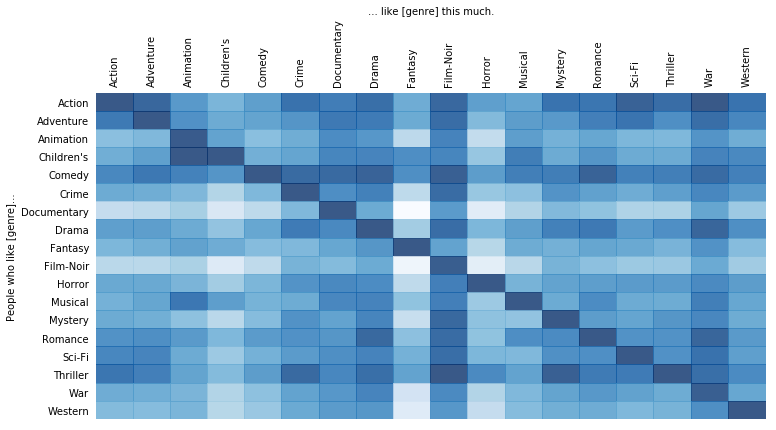

In [11]:
phf.conditional_interest(user_features, item_features)

### Results

1.  People who like Children's movies also like animation, but not vice versa.

2.  Fantasy is very polarized.  If people aren't in the group who rates it 4+ stars, they rate it very low across the board.

3.  War and Film-noir are highly rated across all groups.

4.  There is significant overlap in interest between Horror and Thriller.